*Tutorial based on: https://pyquantnews.com/quickly-compute-value-at-risk-with-monte-carlo/*

In [25]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import time
import warnings
from openbb import obb


warnings.filterwarnings("ignore")

In [26]:
sectors = [
    "XLE",
    "XLF",
    "XLU",
    "XLI",
    "GDX",
    "XLK",
    "XLV", 
    "XLY", 
    "XLP", 
    "XLB", 
    "XOP", 
    "IYR", 
    "XHB", 
    "ITB", 
    "VNQ", 
    "GDXJ", 
    "IYE", 
    "OIH", 
    "XME", 
    "XRT", 
    "SMH", 
    "IBB", 
    "KBE", 
    "KRE", 
    "XTL",]

data = obb.equity.price.historical(
    sectors,
    start_date="2010-01-01",
    provider="yfinance").to_df()
    
data["returns"] = data.groupby("symbol").close.pct_change()
portfolio_stats = data.groupby("symbol").agg(daily_returns=("returns", "mean"))
    
portfolio_stats["weights"] = 1 / len(sectors)
    
covariance_matrix = (
    data
    .pivot(
        columns="symbol", 
        values="returns")
    .dropna()
    .cov())

simulations = 100_000
days = len(data.index.unique())
initial_capital = 100_000

historical_returns = np.full(
    shape=(days, len(sectors)), 
    fill_value=portfolio_stats.daily_returns)

In [27]:
def montecarlo_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return np.percentile(sim_val, alpha)


def conditional_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()


def simulate(L, portfolio_stats, historical_returns):
    portfolio = np.zeros((days, simulations))
    for i in range(0, simulations):
        Z = np.random.normal(size=(days, len(sectors)))
        daily_returns = historical_returns + np.dot(L, Z.T).T
        portfolio[:, i] = (
            np.cumprod(np.dot(daily_returns, portfolio_stats.weights) + 1) * initial_capital
        )
    return pd.DataFrame(portfolio)

In [28]:
L = np.linalg.cholesky(covariance_matrix)

In [29]:
start = time.time()
simulated_portfolio = simulate(L, portfolio_stats, historical_returns)
end = time.time()
print("--- %s seconds ---" % (end - start))

--- 654.2936115264893 seconds ---


In [30]:
alpha = 5
    
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
plt.show()

In [ ]:
@nb.jit(parallel=True)
def simulate_with_numba(sectors, L, weights, historical_returns):
    portfolio = np.zeros((days, simulations))
    n_sectors = len(sectors)
    for i in nb.prange(0, simulations):
        Z = np.zeros((days, n_sectors))
        for d in nb.prange(0, days):
            for s in nb.prange(0, n_sectors):
                Z[d, s] = np.random.normal()
        daily_returns = historical_returns + np.dot(L, Z.T).T
        portfolio[:, i] = (
            np.cumprod(np.dot(daily_returns, weights) + 1) * initial_capital
        )
    return portfolio

In [ ]:
start = time.time()
simulated_portfolio = simulate_with_numba(sectors, L, portfolio_stats.weights.to_numpy(), historical_returns)
simulated_portfolio = pd.DataFrame(simulated_portfolio)
end = time.time()
print("--- %s seconds ---" % (end - start))

--- 9.831171989440918 seconds ---


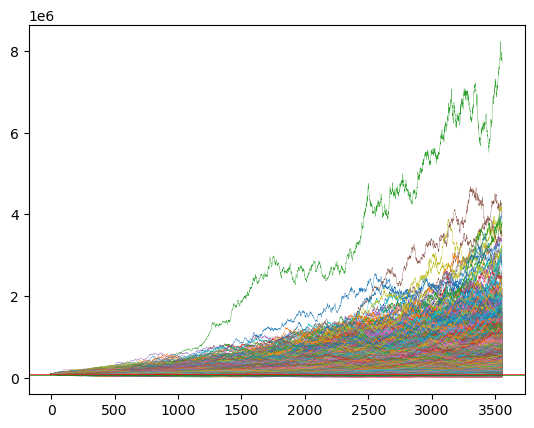

In [ ]:
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
plt.show()

In [ ]:
@nb.njit(parallel=True)
def simulate_with_numba_compiled(sectors, L, weights, historical_returns):
    portfolio = np.zeros((days, simulations))
    n_sectors = len(sectors)
    for i in nb.prange(0, simulations):
        Z = np.zeros((days, n_sectors))
        for d in nb.prange(0, days):
            for s in nb.prange(0, n_sectors):
                Z[d, s] = np.random.normal()
        daily_returns = historical_returns + np.dot(L, Z.T).T
        portfolio[:, i] = (
            np.cumprod(np.dot(daily_returns, weights) + 1) * initial_capital
        )
    return portfolio

In [ ]:
start = time.time()
simulated_portfolio = simulate_with_numba_compiled(sectors, L, portfolio_stats.weights.to_numpy(), historical_returns)
simulated_portfolio = pd.DataFrame(simulated_portfolio)
end = time.time()
print("--- %s seconds ---" % (end - start))

--- 11.682202577590942 seconds ---


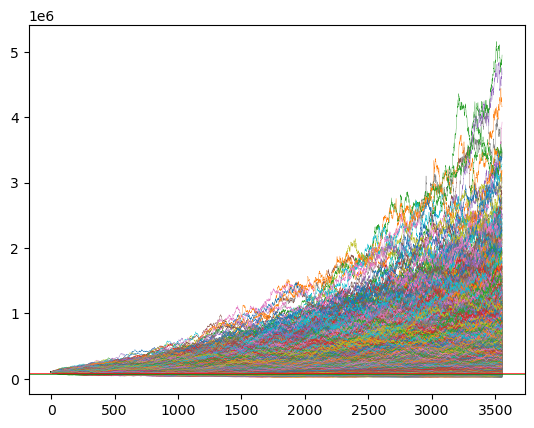

In [ ]:
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
plt.show()